# Weekly_Salesの予測

## モデルの選択理由
- DeptごとにWeekly_Salesの変動に特徴があるので、その違いをうまく捉えることができそうな決定木を使用しているアルゴリズム（今回はRandomForestRegressor,ExtraTreesRegressor）を使用したいと思ったから。

## 工夫した点
- featureの欠損値補完に関して Storeごとにそれぞれの特徴の平均値を求め、対応するStoreの欠損値を補完するようにした(中央値補完も試したが平均値の方が精度が良かった)。これによって、ただ単純に全体の平均値を用いて欠損値を補完した時に比べて大幅に精度の向上ができた。
- trainとtestをマージして前処理をして最後に分割することでコードの数を減らした。
- EDAにおける考察を活かして47週目と51週目には新しくラベルをつけた。
- DateをYearとWeekに変換して処理をしやすくした。

## 課題
- 時系列解析用のアルゴリズムを使っても予測してみる
- データが大きいのが原因で自分の環境では `n_estimators`, `max_depth` 等を取り入れたRandomizedSearchができなかった。（手元の環境では時間がかかり過ぎてしまうため今回は候補をかなり絞って探索した。）

## 提出スコア
2993.26502/2892.23842(上位15%)
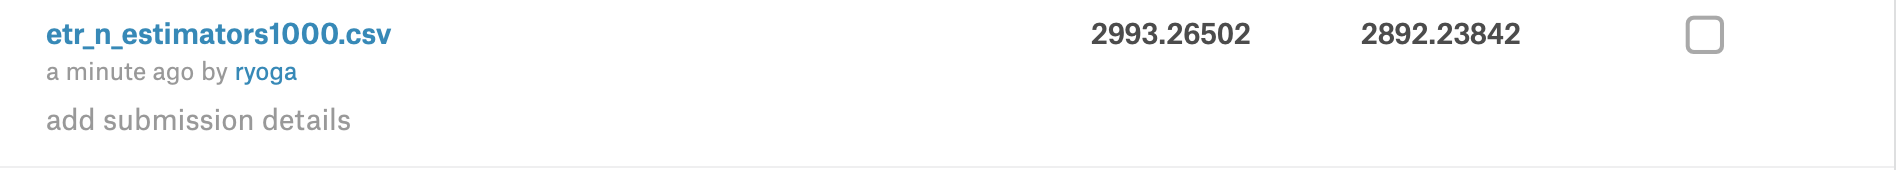

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt

In [2]:
feature = pd.read_csv("./features.csv.zip", parse_dates=True)
stores = pd.read_csv("./stores.csv")
train = pd.read_csv("./train.csv.zip", parse_dates=True)
test = pd.read_csv("./test.csv.zip", parse_dates=True)
sample = pd.read_csv("./sampleSubmission.csv.zip")

In [3]:
#featureの欠損値はStoreごとの平均値を算出して対応するStoreごとに補完することに
for store_num, df in feature.groupby(["Store"]):
    df = df.fillna(df.mean())
    feature = feature.fillna(df)
train_all = pd.merge(pd.merge(train, stores), feature)
test_all = pd.merge(pd.merge(test, stores), feature)
train_all['Split'] = 'Train'
test_all['Split'] = 'Test'
X_all = pd.concat([train_all, test_all], sort=False, ignore_index=False)

#X_all.fillna(0, inplace=True)
#X_all.fillna(X_all[["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4","MarkDown5", "CPI", "Unemployment"]].mean(), inplace=True)
#X_all.fillna(X_all[["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4","MarkDown5", "CPI", "Unemployment"]].median(), inplace=True)

In [4]:
X_all['Temperature'] = (X_all['Temperature'] - 32) * 5/9
train_all.Date = pd.to_datetime(train_all.Date)
train_all["Year"] = train_all.Date.dt.year
train_all["Week"] = train_all.Date.dt.week
test_all.Date = pd.to_datetime(test_all.Date)
test_all["Year"] = test_all.Date.dt.year
test_all["Week"] = test_all.Date.dt.week
X_all.Date = pd.to_datetime(X_all.Date)
X_all["Year"] = X_all.Date.dt.year
X_all["Week"] = X_all.Date.dt.week
X_all["BeforeChristmas"] = X_all.Week == 51
X_all["InThanksGiving"] = X_all.Week == 47
X_all.drop(["Date"], axis=1, inplace=True)

X_dummied = pd.get_dummies(X_all, columns=["IsHoliday", "Type", "BeforeChristmas", "InThanksGiving"])
X_dummied = pd.get_dummies(X_all, columns=["Type"])

train_all_sorted = train_all.sort_values(["Store", "Dept", "Year", "Week"])
test_all_sorted = test_all.sort_values(["Store", "Dept", "Year", "Week"])
X_dummied_sorted = X_dummied.sort_values(["Store", "Dept", "Year", "Week"])

train_prosecced = X_dummied_sorted[X_dummied_sorted.Split == "Train"].drop(["Split"], axis=1)
test_prosecced = X_dummied_sorted[X_dummied_sorted.Split == "Test"].drop(["Split"], axis=1)

train_X = train_prosecced.drop(["Weekly_Sales"], axis=1)
train_y = train_prosecced.Weekly_Sales
test_X = test_prosecced.drop(["Weekly_Sales"], axis=1)

In [ ]:
rfr = RandomForestRegressor(n_estimators=100, verbose=0, n_jobs=30)
rfr.fit(train_X, train_y)

In [6]:
rfr.score(train_X, train_y)

0.9965441038174071

In [8]:
pred = rfr.predict(test_X)
sample.Weekly_Sales = pred
sample.to_csv("./rfr.csv", index=False)

提出結果
3718.75058
3581.69489

In [5]:
etr = ExtraTreesRegressor(n_estimators=100, verbose=0, n_jobs=30)
etr.fit(train_X, train_y)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=30,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [6]:
etr.score(train_X, train_y)

0.9999999999909742

In [7]:
pred = etr.predict(test_X)
sample.Weekly_Sales = pred
sample.to_csv("./etr.csv", index=False)

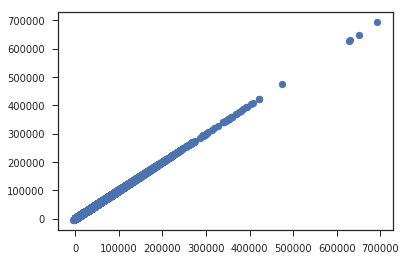

In [8]:
plt.scatter(train_y, etr.predict(train_X))

提出結果3003.54813
2901.92093

ExtraTreesRegressorを用いた方が精度が向上することがわかった。以下はExtraTreesRegressorのハイパーパラメータのチューニングを行う。

# パラメーターチューニング

In [35]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
bootstrap = [True, False]
# Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

random_grid = {'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [36]:
etr = ExtraTreesRegressor(n_estimators=100, verbose=0, n_jobs=30)
etr_random = RandomizedSearchCV(estimator = etr, param_distributions = random_grid, n_iter = 8, cv = 5, verbose=2, 
                                random_state=42, n_jobs = 1)

In [37]:
etr_random.fit(train_X, train_y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] min_samples_split=2, min_samples_leaf=1, bootstrap=True .........
[CV]  min_samples_split=2, min_samples_leaf=1, bootstrap=True, total=   7.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


[CV] min_samples_split=2, min_samples_leaf=1, bootstrap=True .........
[CV]  min_samples_split=2, min_samples_leaf=1, bootstrap=True, total=   7.7s
[CV] min_samples_split=2, min_samples_leaf=1, bootstrap=True .........
[CV]  min_samples_split=2, min_samples_leaf=1, bootstrap=True, total=   7.7s
[CV] min_samples_split=2, min_samples_leaf=1, bootstrap=True .........
[CV]  min_samples_split=2, min_samples_leaf=1, bootstrap=True, total=   7.7s
[CV] min_samples_split=2, min_samples_leaf=1, bootstrap=True .........
[CV]  min_samples_split=2, min_samples_leaf=1, bootstrap=True, total=   8.0s
[CV] min_samples_split=5, min_samples_leaf=1, bootstrap=True .........
[CV]  min_samples_split=5, min_samples_leaf=1, bootstrap=True, total=   7.5s
[CV] min_samples_split=5, min_samples_leaf=1, bootstrap=True .........
[CV]  min_samples_split=5, min_samples_leaf=1, bootstrap=True, total=   7.7s
[CV] min_samples_split=5, min_samples_leaf=1, bootstrap=True .........
[CV]  min_samples_split=5, min_samples_le

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  6.5min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=30,
          oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=8, n_jobs=1,
          param_distributions={'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [38]:
etr_random.best_estimator_

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=5,
          min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=30,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [39]:
etr_random_best = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=5,
          min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=30,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [40]:
etr_random_best.fit(train_X, train_y)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=5,
          min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=30,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [42]:
etr_random_best.score(train_X, train_y)

0.9961360158987796

In [43]:
pred = etr_random_best.predict(test_X)
sample.Weekly_Sales = pred
sample.to_csv("./etr_randomsearch.csv", index=False)

提出結果3075.51008
2976.43826<br>
RandomizedSearchをするとCVの影響からか提出スコア自体は下がってしまった。実際にRandomizedSearchを使用せずに、`min_samples_leaf`, `min_samples_split`, `bootstrap`の値をデフォルト以外に設定してみたところ、提出スコアが下がってしまうので今回はデフォルトのパラメータを用いて提出する。

In [8]:
etr = ExtraTreesRegressor(n_estimators=500, verbose=1, n_jobs=30)

In [9]:
etr.fit(train_X, train_y)

[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:   17.1s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:  1.8min
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:  2.7min finished


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=30,
          oob_score=False, random_state=None, verbose=1, warm_start=False)

In [10]:
pred = etr.predict(test_X)
sample.Weekly_Sales = pred
sample.to_csv("./etr_n_estimators=500.csv", index=False)

[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    0.2s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:    0.6s
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed:    0.8s finished


提出スコア2998.70791
2894.80918

In [8]:
etr = ExtraTreesRegressor(n_estimators=1000, verbose=1, n_jobs=20)

In [9]:
etr.fit(train_X, train_y)

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   24.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   58.2s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  4.7min
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:  6.2min finished


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=20,
          oob_score=False, random_state=None, verbose=1, warm_start=False)

In [10]:
pred = etr.predict(test_X)
sample.Weekly_Sales = pred
sample.to_csv("./etr_n_estimators=1000.csv", index=False)

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    2.7s finished


提出スコア 2993.26502
2892.23842

n_estimatorsを大きくすると提出スコアが向上したが、だんだん収束してきたのでこれを最終提出スコアとする。
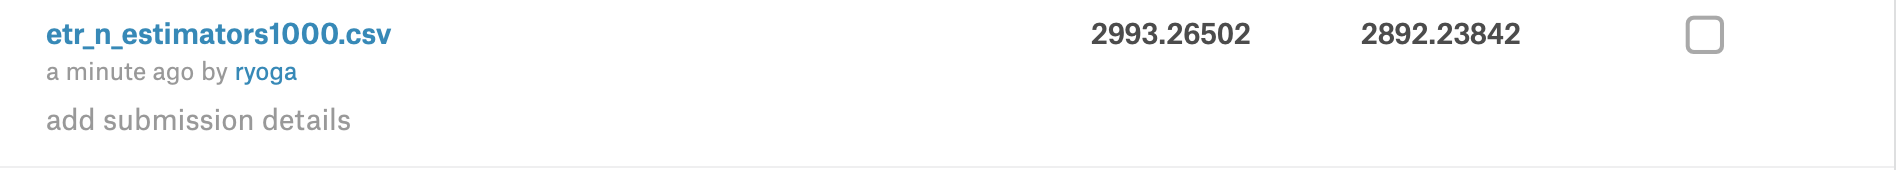

## featureの欠損値をDeptごとの平均値で補完

In [2]:
# feature = pd.read_csv("./features.csv.zip", parse_dates=True)
# stores = pd.read_csv("./stores.csv")
# train = pd.read_csv("./train.csv.zip", parse_dates=True)
# test = pd.read_csv("./test.csv.zip", parse_dates=True)
# sample = pd.read_csv("./sampleSubmission.csv.zip")
# train_all = pd.merge(pd.merge(train, stores), feature)
# test_all = pd.merge(pd.merge(test, stores), feature)
# train_all['Split'] = 'Train'
# test_all['Split'] = 'Test'
# X_all = pd.concat([train_all, test_all], sort=False, ignore_index=True)
# for Dept_num, df in X_all.groupby(["Dept"]):
#     df = df[['MarkDown1', 'MarkDown2', 'MarkDown3',
#        'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',]]
#     df = df.fillna(df.mean())
#     X_all = X_all.fillna(df)
# X_all['Temperature'] = (X_all['Temperature'] - 32) * 5/9
# train_all.Date = pd.to_datetime(train_all.Date)
# train_all["Year"] = train_all.Date.dt.year
# train_all["Week"] = train_all.Date.dt.week
# test_all.Date = pd.to_datetime(test_all.Date)
# test_all["Year"] = test_all.Date.dt.year
# test_all["Week"] = test_all.Date.dt.week
# X_all.Date = pd.to_datetime(X_all.Date)
# X_all["Year"] = X_all.Date.dt.year
# X_all["Week"] = X_all.Date.dt.week
# X_all["BeforeChristmas"] = X_all.Week == 51
# X_all["InThanksGiving"] = X_all.Week == 47
# X_all.drop(["Date"], axis=1, inplace=True)

# X_dummied = pd.get_dummies(X_all, columns=["IsHoliday", "Type", "BeforeChristmas", "InThanksGiving"])
# X_dummied = pd.get_dummies(X_all, columns=["Type"])

# train_all_sorted = train_all.sort_values(["Store", "Dept", "Year", "Week"])
# test_all_sorted = test_all.sort_values(["Store", "Dept", "Year", "Week"])
# X_dummied_sorted = X_dummied.sort_values(["Store", "Dept", "Year", "Week"])

# train_prosecced = X_dummied_sorted[X_dummied_sorted.Split == "Train"].drop(["Split"], axis=1)
# test_prosecced = X_dummied_sorted[X_dummied_sorted.Split == "Test"].drop(["Split"], axis=1)

# train_X = train_prosecced.drop(["Weekly_Sales"], axis=1)
# train_y = train_prosecced.Weekly_Sales
# test_X = test_prosecced.drop(["Weekly_Sales"], axis=1)